# Bigram frequency visualization

In [1]:
import torch 

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pandas import DataFrame

from tqdm import tqdm 

from matplotlib.pyplot import figure
import matplotlib as mpl

from nltk.corpus import stopwords

In [2]:
stopwords = stopwords.words('english')
stopwords.extend(['"', "'", '.', ',', '?', '!', '-', '[CLS]', '[SEP]', 
      ':', '@', '/', '[', ']', '(', ')', 'would', 'like'])
stopwords = set(stopwords)

In [3]:
last_bigram_path = 'bertnet_0.0.6.4_dev_epoch_-1_state_2gram_both.txt'
zero_bigram_path = 'bertnet_0.1.9.1_dev_epoch_-1_state_2gram_both.txt'

In [4]:
def read_bigram(bigram_path):
    bigrams = []
    lines = open(bigram_path).readlines()
    bigram = []
    for li, l in enumerate(lines):
        if(li % 3 == 0):
            l_ = l.split(' ')
            bigram.extend([l_[2], int(l_[4])])
        if(li % 3 == 1):
            l_ = l[:-2].split(' | ')
            cnt_ = 0
            for bi_ in l_[1:]:
                bi_ = bi_.split(' ')
                w1 = bi_[0].split('-')[0]
                w2 = bi_[0].split('-')[1]
                cnt = int(bi_[1])
                if(w1 in stopwords or w2 in stopwords):
                    cnt_ += cnt
            bigram.append(cnt_)
            bigrams.append(bigram)
            bigram = []
    return bigrams

In [5]:
PUNCTUATION = set(['"', "'", '.', ',', '?', '!', '-',  ':', '@', '/', '[', ']', '(', ')'])
PREPOSITION = set(['of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once'])
ADVERBIAL = set(['am', 'is', 'are', 'was', 'where', 'has', 'have', 'had', 'be', 'being', 'been', 'having', 'do', 'does', 'did', 'doing', 
                 'can', 'could', 'shall', 'might', 'must', 'need', 'should', 'would', 'will'])
PRONOUN = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he',
 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves'])
CONJ = set(['and', 'but', 'if', 'or', 'because', 'as', 'until', 'while'])
DET = set(['all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'a', 'an', 'the'])

def get_type(w):
    if('##' in w): return 'subword'
    elif(w in PUNCTUATION): return 'punctuation'
    elif(w in PREPOSITION): return 'preposition'
    elif(w in ADVERBIAL): return 'adverbial'
    elif(w in PRONOUN): return 'pronoun'
    elif(w in CONJ): return 'conj'
    elif(w in DET): return 'det'
    else: return 'content'


def analyze_bigram(bigram_path):
    lines = open(bigram_path).readlines()
    bigrams = []
    bigram = []
    for li, l in enumerate(lines):
        if(li % 3 == 0):
            l_ = l.split(' ')
            bigram.extend([l_[2], int(l_[4])])
        if(li % 3 == 1):
            l_ = l[:-2].split(' | ')
            cnt_dict = {'punctuation': 0, 'subword': 0, 'preposition': 0, 'adverbial': 0, 'pronoun': 0, 
                        'conj': 0, 'det': 0, 'content': 0, 'total': 0, 'base': 2 * bigram[1]}
            for bi_ in l_[1:]:
                bi_ = bi_.split(' ')
                w1 = bi_[0].split('-')[0]
                w2 = bi_[0].split('-')[1]
                
                cnt = int(bi_[1])
                cnt_dict['total'] += 2 * cnt
                
                w1_type = get_type(w1)
                cnt_dict[w1_type] += cnt
                
                w2_type = get_type(w2)
                cnt_dict[w2_type] += cnt
            bigram.append(cnt_dict)
            bigrams.append(bigram)
            bigram = []
    return bigrams

In [6]:
last_bigrams = read_bigram(last_bigram_path)
zero_bigrams = read_bigram(zero_bigram_path)

In [7]:
last_bigrams_class = analyze_bigram(last_bigram_path)
zero_bigrams_class = analyze_bigram(zero_bigram_path)

In [8]:
last_bigrams_class[20]

['1722-1192',
 280,
 {'punctuation': 1,
  'subword': 10,
  'preposition': 237,
  'adverbial': 0,
  'pronoun': 1,
  'conj': 1,
  'det': 96,
  'content': 130,
  'total': 476,
  'base': 560}]

In [92]:
len(last_bigrams_class)

93263

In [41]:
len(zero_bigrams)

136523

In [37]:
last_bigrams[3]

['1792-357', 477, 3]

In [51]:
def plot_bigram(bigrams, interval=10, maxy=5, end_idx=-1):
    bigrams_x = []
    function = []
    content = []

    for bi, b in enumerate(bigrams):
        if(bi % interval == 0):
            bigrams_x.append(bi // interval)
            
            base = np.log(b[1] + 1)
            if(base > maxy): base=maxy
            
            total = b[2]['total'] + 1
            function.append(base * (1 - (b[2]['content'] + 1) / total))
            content.append(base * (b[2]['content'] + 1) / total)
                            
    fig = plt.figure(figsize=(9, 2.5), dpi=200)
    plt.bar(x=bigrams_x[:end_idx], height=function[:end_idx], color='tab:orange', label='Function')
    plt.bar(x=bigrams_x[:end_idx], height=content[:end_idx], bottom=function[:end_idx], color='tab:blue', label='Content')
    
    plt.legend(loc='upper right')
    
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=False,
    labelbottom=True) # labels along the bottom edge are off
    return 

In [34]:
def plot_bigram_detailed(bigrams, interval=10, maxy=10, end_idx=-1):
    bigrams_x = []
    punctuation = []
    subword = []
    preposition = []
    adverbial = [] 
    pronoun = []
    conj = []
    det = []
    content = []
    
    for bi, b in enumerate(bigrams):
        if(bi % interval == 0):
            bigrams_x.append(bi // interval)
            
            base = np.log(b[2]['base'] + 1)
            if(base > maxy): base=maxy
            total = b[2]['total'] + 1
            punctuation.append(base * b[2]['punctuation'] / total)
            subword.append(base * b[2]['subword'] / total)
            preposition.append(base * b[2]['preposition'] / total)
            adverbial.append(base * b[2]['adverbial'] / total)
            pronoun.append(base * b[2]['pronoun'] / total)
            conj.append(base * b[2]['conj'] / total)
            det.append(base * b[2]['det'] / total)
            content.append(base * (b[2]['content'] + 1) / total)
      
    bigrams_x = np.array(bigrams_x)
    punctuation = np.array(punctuation)
    subword = np.array(subword)
    preposition = np.array(preposition)
    adverbial = np.array(adverbial)
    pronoun = np.array(pronoun)
    conj = np.array(conj)
    det = np.array(det)
    content = np.array(content)
    
    
    fig = plt.figure(figsize=(8.5, 2.5), dpi=200)
    
    plt.bar(x=bigrams_x[:end_idx], height=punctuation[:end_idx], label='Punctuation')
    plt.bar(x=bigrams_x[:end_idx], height=subword[:end_idx], bottom=punctuation[:end_idx], label='Subword')
    plt.bar(x=bigrams_x[:end_idx], height=preposition[:end_idx], bottom=punctuation[:end_idx] + subword[:end_idx], label='Preposition')
    plt.bar(x=bigrams_x[:end_idx], height=adverbial[:end_idx], bottom=punctuation[:end_idx] + subword[:end_idx] + preposition[:end_idx], label='Adverbial')
    plt.bar(x=bigrams_x[:end_idx], height=pronoun[:end_idx], bottom=punctuation[:end_idx] + subword[:end_idx] + preposition[:end_idx] + adverbial[:end_idx], 
            label='Pronoun')
    plt.bar(x=bigrams_x[:end_idx], height=conj[:end_idx], bottom=punctuation[:end_idx] + subword[:end_idx] + preposition[:end_idx] + adverbial[:end_idx] +
           pronoun[:end_idx], label='Conjunction')
    plt.bar(x=bigrams_x[:end_idx], height=det[:end_idx], bottom=punctuation[:end_idx] + subword[:end_idx] + preposition[:end_idx] + adverbial[:end_idx] +
           pronoun[:end_idx] + conj[:end_idx], label='Determiner')
    # plt.bar(x=bigrams_x[:end_idx], height=content[:end_idx], bottom=punctuation[:end_idx] + subword[:end_idx] + preposition[:end_idx] + adverbial[:end_idx] +
    #        pronoun[:end_idx] + conj[:end_idx] + det[:end_idx], label='Content', color='tomato')
    plt.bar(x=bigrams_x[:end_idx], height=content[:end_idx], bottom=punctuation[:end_idx] + subword[:end_idx] + preposition[:end_idx] + adverbial[:end_idx] +
           pronoun[:end_idx] + conj[:end_idx] + det[:end_idx], label='Content', color='lightsalmon')
    # plt.legend(loc='upper right', bbox_to_anchor=(2, 0.5))
    
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=False,
    labelbottom=True) # labels along the bottom edge are off
    return 

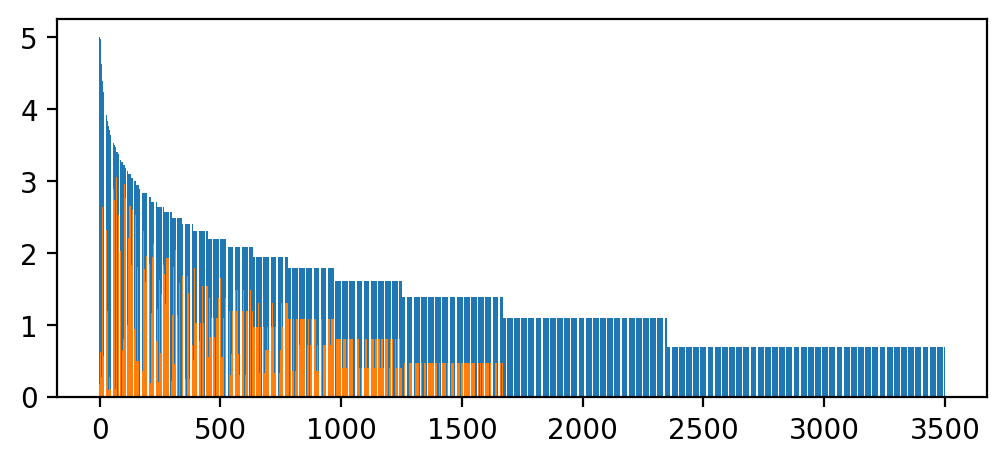

In [70]:
plot_bigram(last_bigrams, interval=25, end_idx=3500)

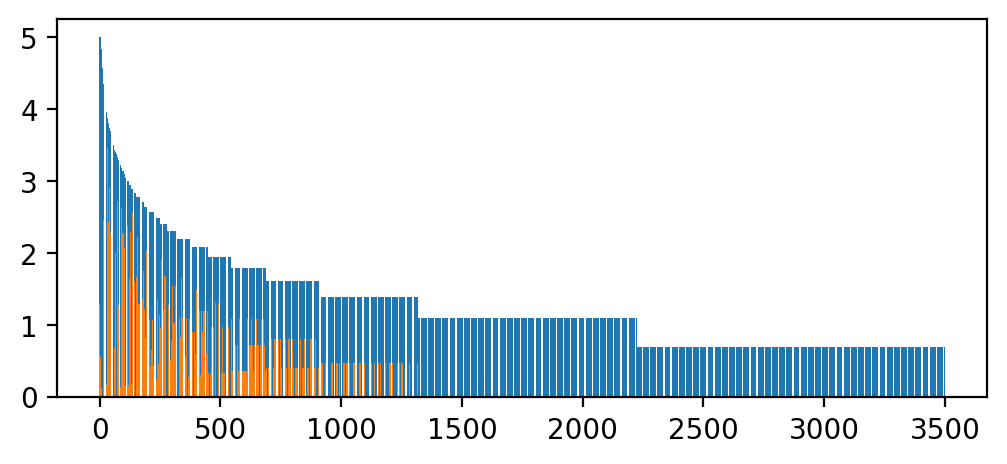

In [69]:
plot_bigram(zero_bigrams, interval=25, end_idx=3500)

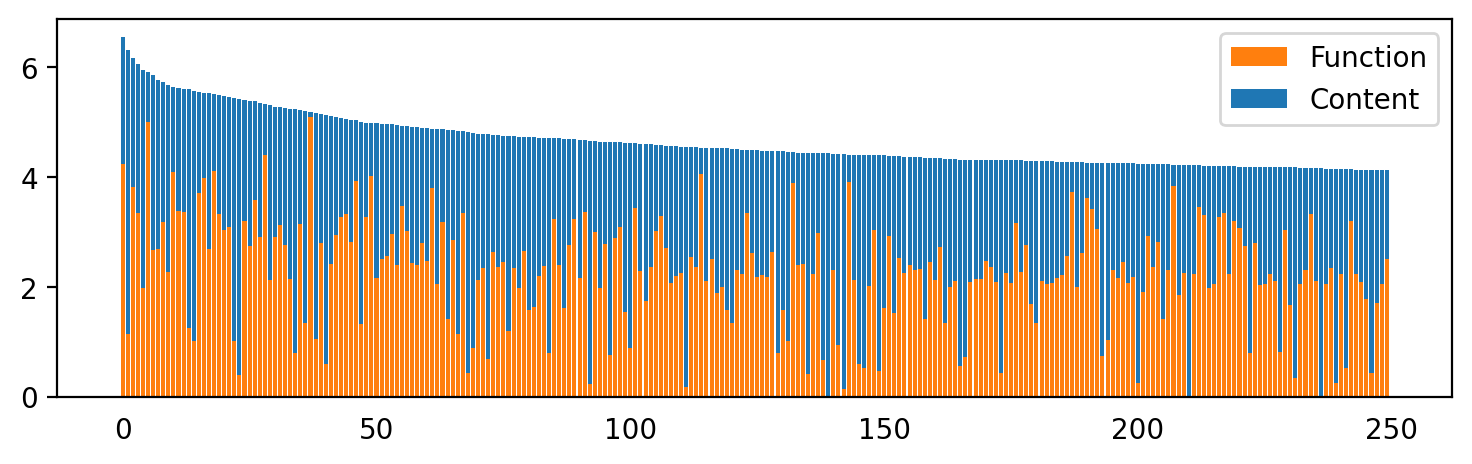

In [53]:
plot_bigram(last_bigrams_class, interval=2, maxy=100, end_idx=250)

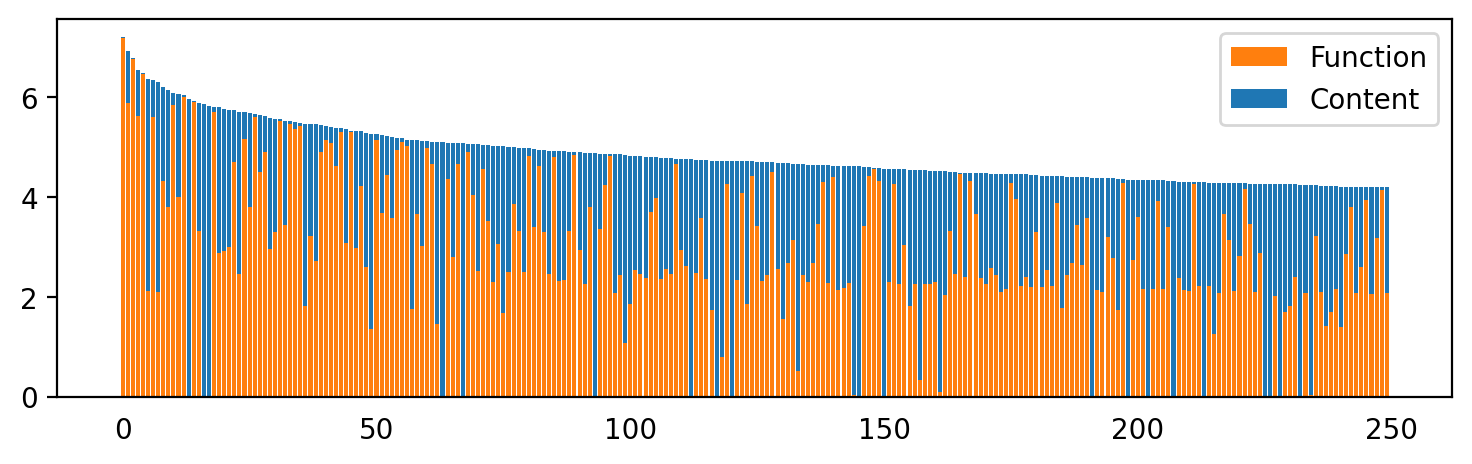

In [52]:
plot_bigram(zero_bigrams_class, interval=2, maxy=100, end_idx=250)

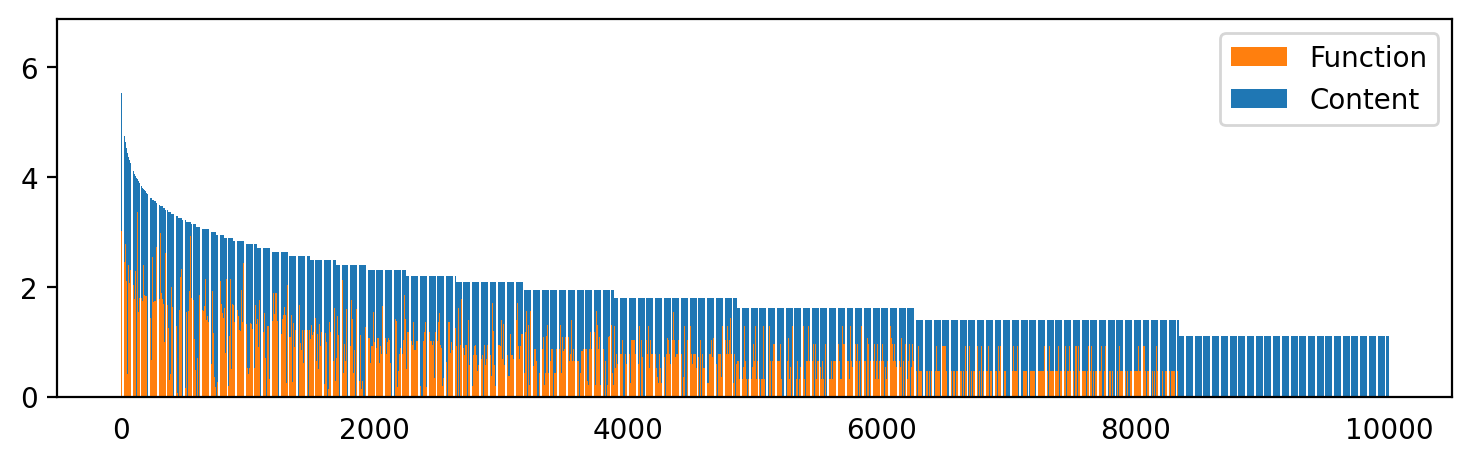

In [55]:
plot_bigram(last_bigrams_class, interval=5, end_idx=10000, maxy=7)

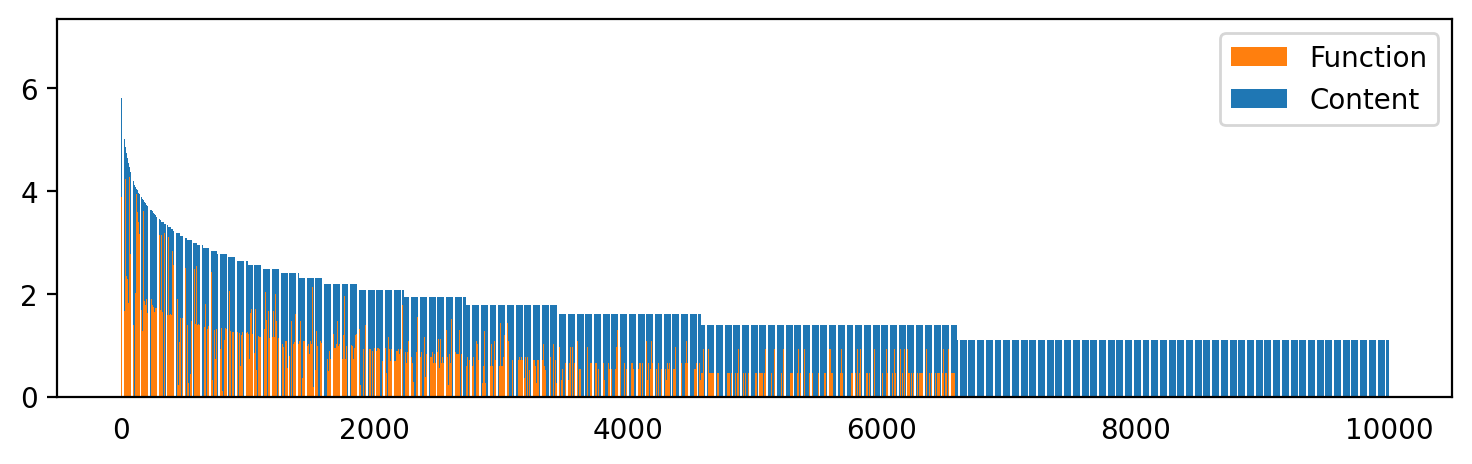

In [54]:
plot_bigram(zero_bigrams_class, interval=5, end_idx=10000, maxy=7)

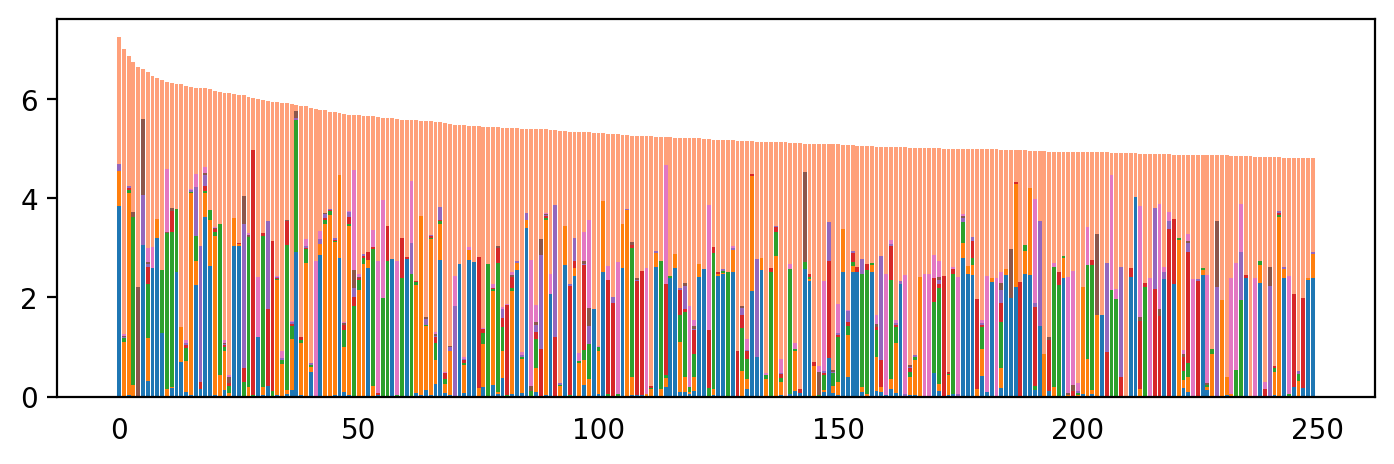

In [35]:
plot_bigram_detailed(last_bigrams_class, interval=2, end_idx=250)

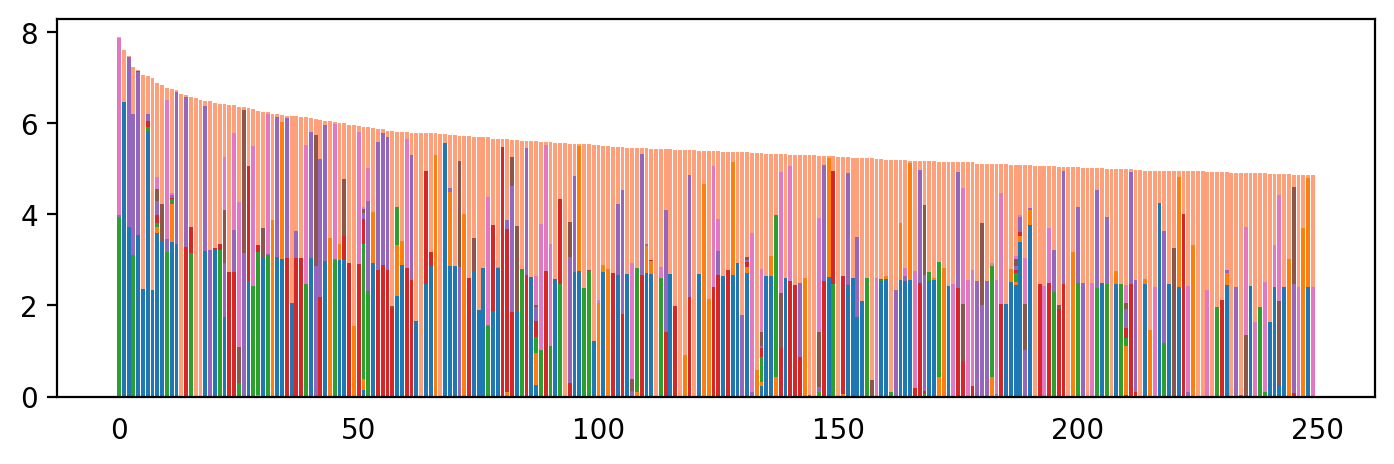

In [36]:
plot_bigram_detailed(zero_bigrams_class, interval=2, end_idx=250)

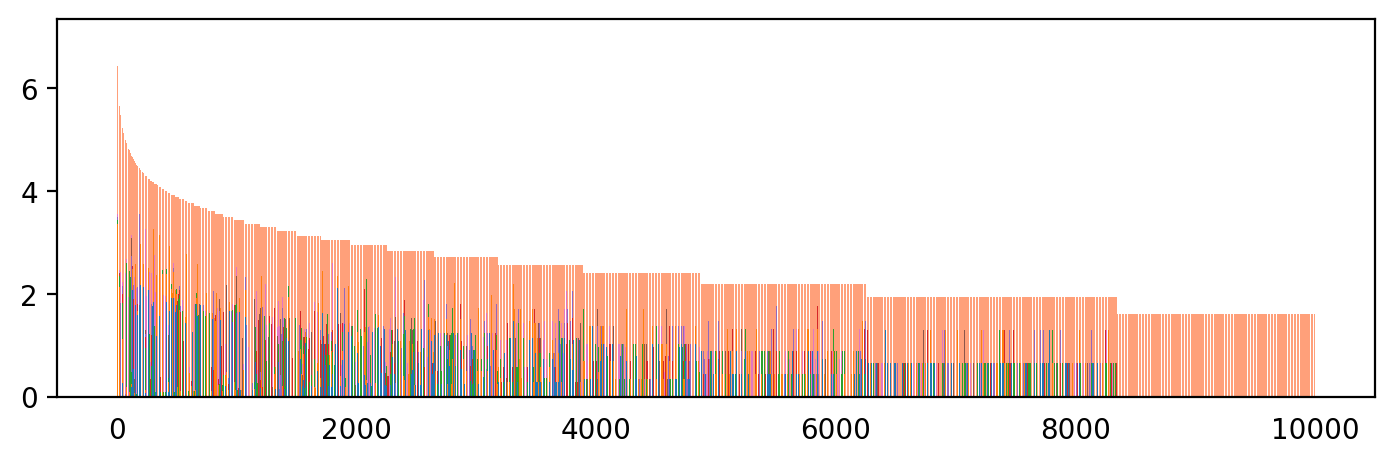

In [37]:
plot_bigram_detailed(last_bigrams_class, interval=5, end_idx=10000, maxy=7)

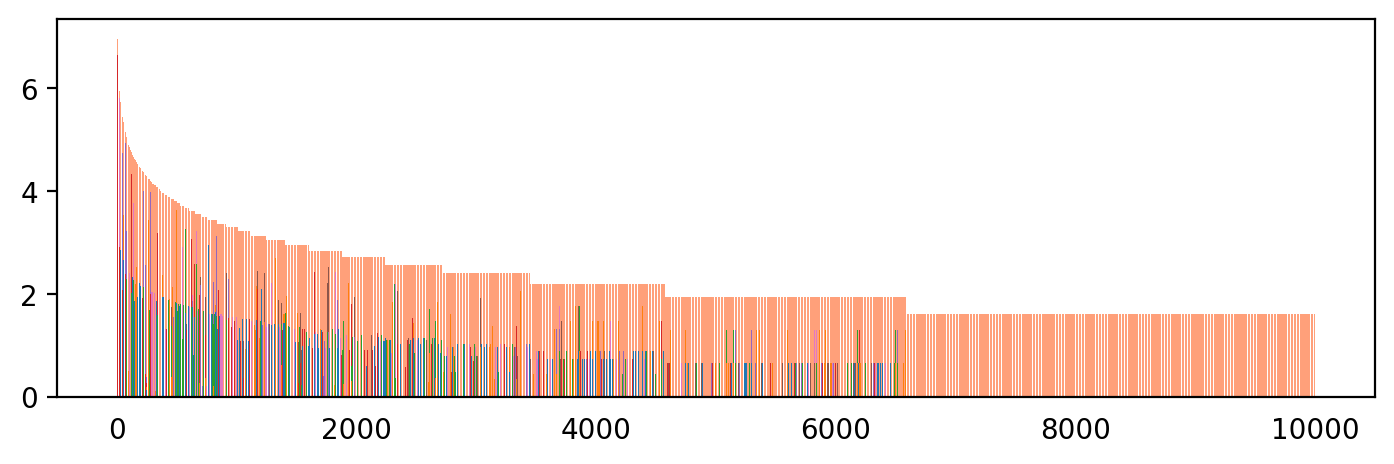

In [38]:
plot_bigram_detailed(zero_bigrams_class, interval=5, end_idx=10000, maxy=7)